In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import seaborn as sns
py.init_notebook_mode(connected=True)

### Loading the data and checking the data types

In [2]:
df= pd.read_csv('data/income_data_2017_clean_zeros.csv.bz2', compression='bz2', index_col='peridnum')

In [3]:
#This code is way shoreter then reading the csv to a dictionary
fips_to_data_dict = pd.read_csv('./data/fips_to_state.csv', header=None, index_col=0).to_dict()[1]
df['state_ab']= [fips_to_data_dict[code] for code in df['gestfips']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100542 entries, 0521321306930948100101 to 5997506669009518100102
Columns: 654 entries, hrecord to state_ab
dtypes: float64(35), int64(618), object(1)
memory usage: 502.4+ MB


### Plotting the age distribution 

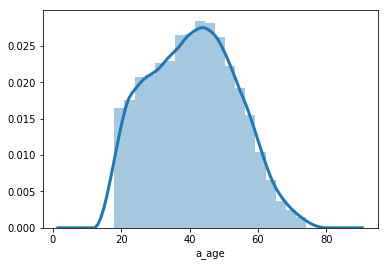

In [4]:
sns.distplot(df['a_age'], bins=19,kde_kws={"lw": 3, "kernel":"cos", "bw":5.5})
plt.xlabel
plt.show()

#### Basic income statistics capped at ~ 17000 a year, which is close to 8 hours at workday minimum wage

In [5]:
df[df.ern_val > 17000].ern_val.describe()

count     71019.000000
mean      53181.148087
std       54775.914770
min       17001.000000
25%       27040.000000
50%       40000.000000
75%       60000.000000
max      619221.000000
Name: ern_val, dtype: float64

### Plotting the earnings distribution (capped at 200,000) 

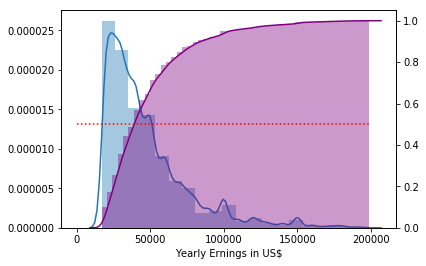

In [6]:
valid_erns = df.ern_val[(df.ern_val < 200000) & (df.ern_val > 17000)]
fig , ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.distplot(valid_erns,kde=True, ax=ax1, bins=20)
sns.distplot(valid_erns,hist_kws=dict(cumulative=True),
             kde_kws={"cumulative":True}, ax=ax2, color='purple')
plt.plot([0, 200000], [0.5, 0.5], 'r:',axes=ax2)
ax1.set(xlabel='Yearly Ernings in US$')
plt.show()

### Boxplot of earnings by state, filtering only income lower then $8000 per year

In [7]:
df_filter_income = df.loc[(df.ern_val > 8000)]

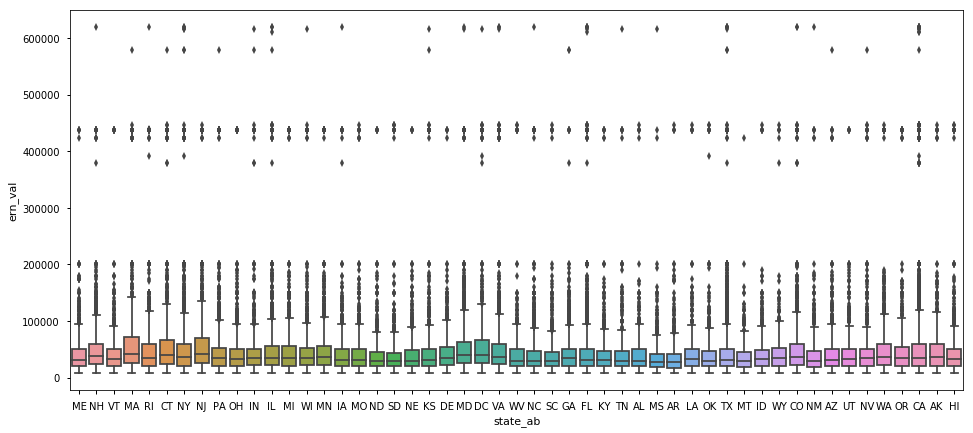

In [8]:
sns.set_context("notebook")
sns.mpl.rc("figure", figsize=(16,7))
sns.boxplot(x='state_ab', y='ern_val', data=df_filter_income)

plt.show()

### Something weird is happening at 200K, will need to check this, meanwhile I just filter everything above 200K

In [9]:
df_filter_income = df.loc[(df.ern_val < 200000) & (df.ern_val > 8000)]

state_means = df_filter_income[['state_ab', 'ern_val']].groupby('state_ab').mean().sort_values(by='ern_val')
state_means.columns=['Mean Ernings']
state_med = df_filter_income[['state_ab', 'ern_val']].groupby('state_ab').median().sort_values(by='ern_val')
state_med.columns=['Median Ernings']

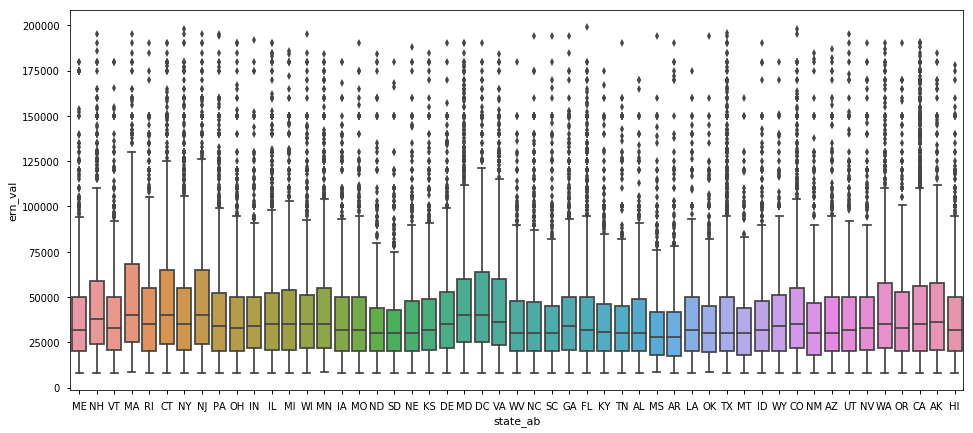

In [10]:
sns.set_context("notebook")
sns.mpl.rc("figure", figsize=(16,7))
sns.boxplot(x='state_ab', y='ern_val', data=df_filter_income)

plt.show()

#### This Seems to make more sense

### Examining the mean Vs. Median earnings per state

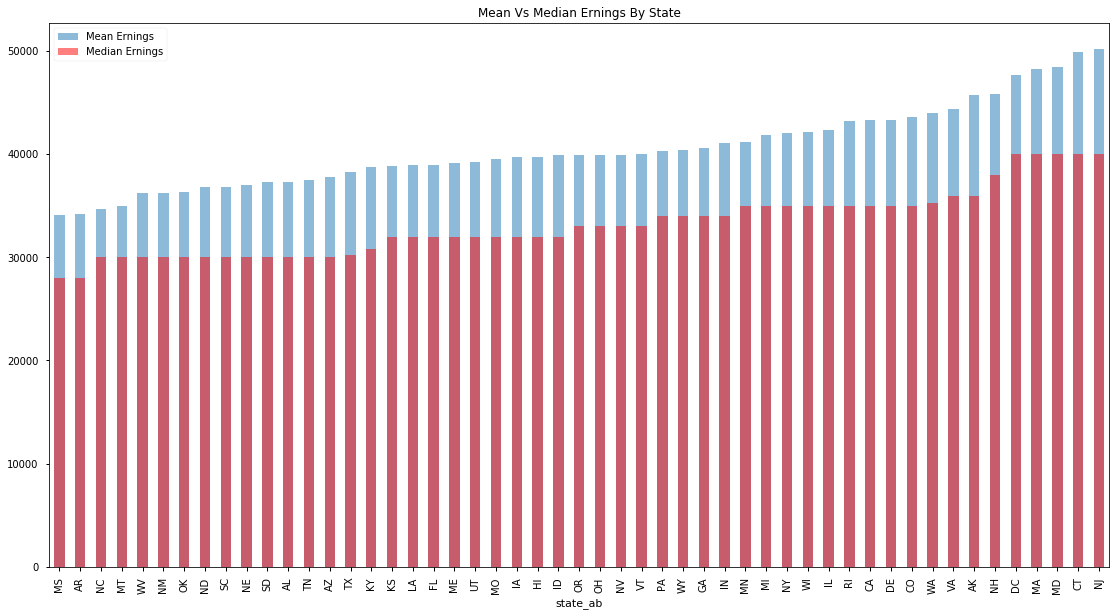

In [11]:
fig , ax1 = plt.subplots()
state_means.plot(kind='bar', figsize=(19,10),alpha=0.5, ax=ax1, title='Mean Vs Median Ernings By State')
state_med.plot(kind='bar', figsize=(19,10),color='r',ax=ax1, alpha=0.5)
plt.show()

## A heat map of mean earning by state

In [12]:
states = state_means.index.values
values = state_means['Mean Ernings'].values

In [13]:
data = [ dict(
        type='choropleth',
        #autocolorscale = True,
        colorscale = 'Viridis',
        locations = states,
        z = values,
        locationmode = 'USA-states',
        text = states,
        colorbar = dict(
            title = "USD")
        ) ]

layout = dict(
        title = '2007 USA Mean Income By State <br> Population Mean = ${:2.2f}k <br> STD = {:2.2f}k'.format(np.mean(values)/1000, np.std(values)/1000),
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = False))
    
fig = dict( data=data, layout=layout )
py.iplot(fig)

### And a quick comparison between male and female shows that men earn about 1.4 times the salary of women. (Some states are worse than others)

In [14]:
males = df_filter_income[df_filter_income['a_sex'] == 1]
female = df_filter_income[df_filter_income['a_sex'] == 2]
male_state_means = males[['state_ab', 'ern_val']].groupby('state_ab').mean().sort_values(by='ern_val')
female_state_means = female[['state_ab', 'ern_val']].groupby('state_ab').mean().sort_values(by='ern_val')
ratio = male_state_means['ern_val'].values/female_state_means['ern_val'].values

In [15]:
# I should really move this to its own function
data = [ dict(
        type='choropleth',
        colorscale = 'Viridis',
        #autocolorscale = False,
        locations = states,
        z = ratio,
        locationmode = 'USA-states',
        text = states,
        colorbar = dict(
            title = "USD")
        ) ]

layout = dict(
        title = '2007 USA Male Female Mean Income Ratio By State <br> Population Mean = {:1.2f} STD = {:1.2f}'.format(
            np.mean(ratio), np.std(ratio)),
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = False))
    
fig = dict( data=data, layout=layout )
py.iplot(fig)